In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [251]:
df_original = pd.read_csv('../data/_data.csv')
df = df_original.copy()
#  удаляем столбцы 'Unnamed: 0', 'Тип', 'Телефоны', 'Описание', 'Название ЖК', 'Серия дома', 'Мусоропровод','Ссылка на объявление', 'Лифт'
df.drop(columns=['Unnamed: 0', 'Тип', 'Телефоны', 'Описание', 'Название ЖК', 'Серия дома', 'Мусоропровод','Ссылка на объявление', 'Лифт'], inplace=True)

In [252]:
# в цене отбрасываем что после цены
def extract_first_number(val):
    if pd.isna(val):
        return np.nan
    val = str(val)
    # первое число (целое или с запятой или точкой)
    match = re.search(r'\d+[\d,.]*', val)
    if match:
        # оставляем только найденное число, удаляем пробелы, заменяем запятую на точку
        number_str = match.group(0).replace(' ', '').replace(',', '.')
        try:
            return float(number_str)
        except ValueError:
            return np.nan
    return np.nan

df['Цена'] = df['Цена'].apply(extract_first_number)

# в площади оставляем первую площадь (отбрасываем все до /)
def extract_total_area(val):
    if pd.isna(val):
        return None
    val = str(val) 
    return float(val.split('/')[0])

df['Площадь, м2'] = df['Площадь, м2'].apply(extract_total_area)

In [253]:
# удаляем время до метро
def extract_station(metro_str):
    if pd.isna(metro_str):
        return None
    # ищем "м. " и захватываем все до первой скобки или конца строки
    match = re.search(r'м\.\s*([^(\n\r]+)', metro_str)
    if match:
        # возвращаем название станции с обрезанием пробелов
        return match.group(1).strip()
    return metro_str  # Если не совпало, возвращаем исходное значение

df['Метро'] = df['Метро'].apply(extract_station)


In [254]:
# в столбце количество комнат оставляем только число комнат
def extract_room_number(value):
    if pd.isna(value):
        return None
    # Ищем первое число в строке
    match = re.search(r'\d+', str(value))
    if match:
        return int(match.group(0))
    return None

df['Количество комнат'] = df['Количество комнат'].apply(extract_room_number)


In [255]:
# заполняем пропуски
# Количество комнат
# Количество комнат преобразуем в число, заполним по медиане внутри групп по площади
df['Количество комнат'] = pd.to_numeric(df['Количество комнат'], errors='coerce')
medians = df.groupby('Площадь, м2')['Количество комнат'].transform('median')
df['Количество комнат'] = df['Количество комнат'].fillna(medians)
global_med = df['Количество комнат'].median()
df['Количество комнат'] = df['Количество комнат'].fillna(global_med).round().astype('Int64')
# метро отсутствующие меняем на "unknown"
df['Метро'] = df['Метро'].fillna('unknown')
# парковка отсутствующие меняем на "unknown"
df['Парковка'] = df['Парковка'].fillna('unknown')
# ремонт
df['Ремонт'] = df['Ремонт'].fillna(df['Ремонт'].mode()[0])
# площадь комнат
def extract_mean_room_area(val):
    if pd.isna(val):
        return None
    numbers = re.findall(r'\d+', str(val))
    if numbers:
        return np.mean([int(n) for n in numbers])
    return None
df['Площадь комнат, м2'] = df['Площадь комнат, м2'].apply(extract_mean_room_area)
df['Площадь комнат, м2'] = df['Площадь комнат, м2'].fillna(df['Площадь комнат, м2'].median())
# балкон
df['Балкон'] = df['Балкон'].fillna('unknown')
# окна
df['Окна'] = df['Окна'].fillna(df['Окна'].mode()[0])
# санузел
df['Санузел'] = df['Санузел'].fillna('unknown')
# Заполняем пустые значения в столбце "Можно с детьми/животными" 'unknown'
df['Можно с детьми/животными'] = df['Можно с детьми/животными'].fillna('unknown')
# Заполняем пустые значения в столбце "Дополнительно" 'unknown'
df['Дополнительно'] = df['Дополнительно'].fillna('unknown')
# Заполняем пустые значения в столбце "Высотка потолков" средним значением по датафрейму с удаленными выбросами(3.00)
df['Высота потолков, м'] = df['Высота потолков, м'].fillna(3.00)

In [256]:
# удаляем выбросы по цене
df_mean = df['Цена'].mean()
df_std = df['Цена'].std()
df = df[(df['Цена'] > df_mean - 0.5 * df_std) & (df['Цена'] < df_mean + 2 * df_std)]

In [257]:
# переименовываем столбцы
df.rename(columns={
    'ID  объявления': 'id',
    'Количество комнат': 'rooms',
    'Метро': 'metro',
    'Адрес': 'address',
    'Площадь, м2': 'area',
    'Дом': 'building_info',
    'Парковка': 'parking',
    'Цена': 'price',
    'Ремонт': 'renovation',
    'Площадь комнат, м2': 'room_area',
    'Балкон': 'balcony',
    'Окна': 'windows',
    'Санузел': 'bathroom',
    'Можно с детьми/животными': 'allowed_children_pets',
    'Дополнительно': 'additional',
    'Высота потолков, м': 'ceiling_height'
}, inplace=True)

In [258]:
# удаляем выбросы по площади
df_mean = df['area'].mean()
df_std = df['area'].std()
df = df[(df['area'] > df_mean - 0.5 * df_std) & (df['area'] < df_mean + 2 * df_std)]

In [259]:
# удаляем столбец additional
df.drop(columns=['additional'], inplace=True)

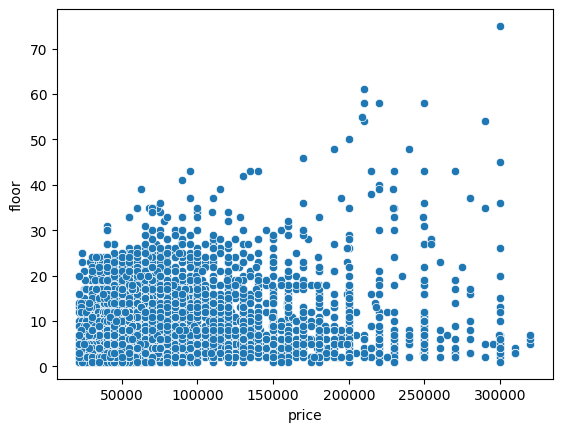

In [260]:
# оставляем в столбце building_info только номер этажа и переименуем в floor
df['building_info'] = df['building_info'].str.split('/').str[0].astype(int)
df.rename(columns={'building_info': 'floor'}, inplace=True)
# удаляем выброс по этажу
sns.scatterplot(data=df, x = 'price', y = 'floor')
df = df[df['floor'] != 75]

In [261]:
#Удаляем адрес, оставляем только город
df['city'] = df['address'].str.split(',').str[0]
df.drop(columns=['address'], inplace=True)
df.head(2)

,id,rooms,metro,area,floor,parking,price,renovation,room_area,balcony,windows,bathroom,allowed_children_pets,ceiling_height,city
4,273614615,2,Арбатская,58.0,12,unknown,225000.0,Евроремонт,19.0,unknown,На улицу и двор,Совмещенный (2),unknown,3.9,Москва
7,274475342,3,Смоленская,98.0,2,подземная,250000.0,Евроремонт,21.0,unknown,Во двор,"Совмещенный (1), Раздельный (1)","Можно с детьми, Можно с животными",3.2,Москва


In [262]:
# сохраняем отредактированный датафрейм
# df.to_csv('data.csv', encoding='utf-8')

In [ ]:
# проверяем по числовым значениям минимальные и максимальные
# min_floor = df['price'].min()
# max_floor = df['price'].max()
# print(min_floor, max_floor)
# проверяем по категориальным и числовым значениям уникальные значения и сколько их
# unique_val = df['metro'].unique()
# print(unique_val)
# unique_values = df['metro'].nunique()
# print(unique_values)

['Арбатская' 'Смоленская' 'Кропоткинская' 'Боровицкая' 'Краснопресненская'
 'Баррикадная' 'Марк' 'Алтуфьево' 'Долгопрудная' 'Новодачная'
 'Селигерская' 'Кузнецкий мост' 'Проспект Мира' 'Трубная' 'Сухаревская'
 'Комсомольская' 'Цветной бульвар' 'Рижская' 'Достоевская' 'Марьина роща'
 'Коломенская' 'Кожуховская' 'Технопарк' 'Ленинский проспект'
 'Автозаводская' 'Пражская' 'Алма-Атинская' 'Царицыно' 'Тульская'
 'Шипиловская' 'Кантемировская' 'Зябликово' 'Орехово' 'Дубровка'
 'Чертановская' 'Каховская' 'ЗИЛ' 'Павелецкая' 'Нагорная' 'Каширская'
 'Крымская' 'Верхние котлы' 'Красногвардейская' 'unknown' 'Лесопарковая'
 'Покровское' 'Домодедовская' 'Аннино' 'Варшавская' 'Нагатинская'
 'Крестьянская застава' 'Пролетарская' 'Площадь Гагарина'
 'Улица Академика Янгеля' 'Нахимовский проспект' 'Севастопольская' 'Битца'
 'Южная' 'Новочеркасская' 'Ладожская' 'Лесная' 'Площадь Ленина'
 'Проспект Большевиков' 'Академическая' 'Девяткино' 'Гражданский проспект'
 'Площадь Александра Невского' 'Московская'